In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mimg
%matplotlib inline
from PIL import Image
from scipy import misc
import random

import tensorflow as tf

from tensorflow.keras import models, layers
import keras
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model

from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, BatchNormalization
from keras.layers import UpSampling2D, Dropout, Add, Multiply, Subtract, AveragePooling2D
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.core import Dense, Lambda
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, Permute, Flatten

from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import InceptionV3

from keras.optimizers import * 
from keras.callbacks import *
from keras.activations import *

from sklearn.metrics import classification_report, confusion_matrix
import pathlib

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
tf.__version__ #The tensorflow version used here is '2.6.4'

'2.6.4'

In [4]:
!nvidia-smi

Sat Aug 27 15:38:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    32W / 250W |    377MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
BATCH_SIZE = 16
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=100

In [6]:
train_loc = '../input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Train'
val_loc = '../input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val'
test_loc = '../input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Test'

In [7]:
traindata = ImageDataGenerator()
train_ds = traindata.flow_from_directory(directory=train_loc, target_size=(224,224),batch_size=BATCH_SIZE, 
                                         shuffle=True, seed=12)

valdata = ImageDataGenerator()
val_ds = valdata.flow_from_directory(directory=val_loc, target_size=(224,224),batch_size=BATCH_SIZE, 
                                     shuffle=True, seed=12)

testdata = ImageDataGenerator()
test_ds = testdata.flow_from_directory(directory=test_loc, target_size=(224,224),batch_size=BATCH_SIZE, 
                                       shuffle=True, seed = 12)

Found 2142 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 45 images belonging to 2 classes.


In [8]:
train_ds.class_indices

{'Monkeypox': 0, 'Others': 1}

In [9]:
IMG_Shape = (IMAGE_SIZE, IMAGE_SIZE) + (3,)
IMG_Shape

(224, 224, 3)

In [10]:
def create_model(input_shape, n_classes , optimizer, fine_tune):
    """
    Compiles a model integrated with MobileNetV2 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = Xception(input_shape= IMG_Shape, weights='imagenet', include_top=False)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = tf.keras.layers.Dense(2000, activation = 'relu')(top_model)
    top_model = tf.keras.layers.Dropout(0.3)(top_model) 
    top_model = tf.keras.layers.Dense(1000, activation = 'relu')(top_model)
    top_model = tf.keras.layers.Dropout(0.2)(top_model)    
    top_model = tf.keras.layers.Dense(200, activation = 'relu')(top_model)
    top_model = tf.keras.layers.Dropout(0.15)(top_model)
    output_layer = tf.keras.layers.Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=opt, 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    
    return model

**Training the model without Fine-Tuning**

In [11]:
input_shape = (224, 224, 3)
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
n_classes = 2
ft=-1

# First we'll train the model without Fine-tuning
model_noFt = create_model(input_shape, n_classes, opt, fine_tune=ft)

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
_____________________________

In [12]:
len(model_noFt.layers)

140

In [13]:
from collections import Counter
counter = Counter(train_ds.classes)                       
max_val = float(max(counter.values()))
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 1.1857142857142857, 1: 1.0}

In [14]:
history = model_noFt.fit(train_ds,
                    epochs = 50,
                    #steps_per_epoch = STEP_SIZE_TRAIN,
                    #class_weight = class_weights,
                    validation_data = val_ds,
                    #validation_steps = STEP_SIZE_VALID,
                    #callbacks=[checkpoint, early_stop, PlotLossesKeras()]
                    )

Epoch 1/50
134/134 [==============================] - 27s 137ms/step - loss: 7.4771 - accuracy: 0.6125 - val_loss: 2.3791 - val_accuracy: 0.7738
Epoch 2/50
134/134 [==============================] - 10s 74ms/step - loss: 4.2832 - accuracy: 0.6755 - val_loss: 1.6242 - val_accuracy: 0.6857
Epoch 3/50
134/134 [==============================] - 10s 74ms/step - loss: 3.0359 - accuracy: 0.7087 - val_loss: 1.5714 - val_accuracy: 0.6762
Epoch 4/50
134/134 [==============================] - 10s 75ms/step - loss: 2.5819 - accuracy: 0.7246 - val_loss: 2.5082 - val_accuracy: 0.5429
Epoch 5/50
134/134 [==============================] - 10s 73ms/step - loss: 2.1520 - accuracy: 0.7325 - val_loss: 1.6542 - val_accuracy: 0.7143
Epoch 6/50
134/134 [==============================] - 10s 74ms/step - loss: 1.9146 - accuracy: 0.7572 - val_loss: 1.4792 - val_accuracy: 0.7119
Epoch 7/50
134/134 [==============================] - 10s 75ms/step - loss: 1.4628 - accuracy: 0.7754 - val_loss: 1.2348 - val_accuracy

In [15]:
model_preds = model_noFt.predict(test_ds,test_ds.samples//test_ds.batch_size+1)
model_pred_classes = np.argmax(model_preds , axis=1)

from sklearn.metrics import accuracy_score
true_classes = test_ds.classes
acc = accuracy_score(true_classes, model_pred_classes)
print("Xception Model Accuracy: {:.2f}%".format(acc * 100))

# model_preds = model.predict(val_data,val_data.samples//val_data.batch_size+1)
# model_pred_classes = np.argmax(model_preds , axis=1)


# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# true_classes = val_data.classes
# acc = accuracy_score(true_classes, model_pred_classes)
# print("MobileNetV2 Model Accuracy: {:.2f}%".format(acc * 100))

# print('Precision: %.3f' % precision_score(true_classes, model_pred_classes))
# print('Recall: %.3f' % recall_score(true_classes, model_pred_classes))
# print('F1 Score: %.3f' % f1_score(true_classes, model_pred_classes))

Xception Model Accuracy: 48.89%


In [16]:
print(confusion_matrix(test_ds.classes, model_pred_classes))
print('Classification Report')
target_names = ['Monkeypox', 'Others']
print(classification_report(test_ds.classes, model_pred_classes, target_names=target_names))

[[11  9]
 [14 11]]
Classification Report
              precision    recall  f1-score   support

   Monkeypox       0.44      0.55      0.49        20
      Others       0.55      0.44      0.49        25

    accuracy                           0.49        45
   macro avg       0.49      0.49      0.49        45
weighted avg       0.50      0.49      0.49        45



(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

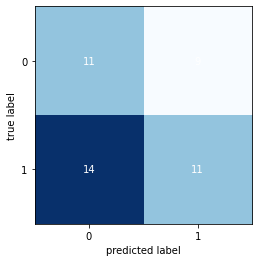

In [17]:
from mlxtend.plotting import plot_confusion_matrix
x = confusion_matrix(test_ds.classes, model_pred_classes)
plot_confusion_matrix(x)

In [18]:
# Get the names of the ten classes
class_names = test_ds.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Greens, #Blues, YlGnBu, YlOrRd
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

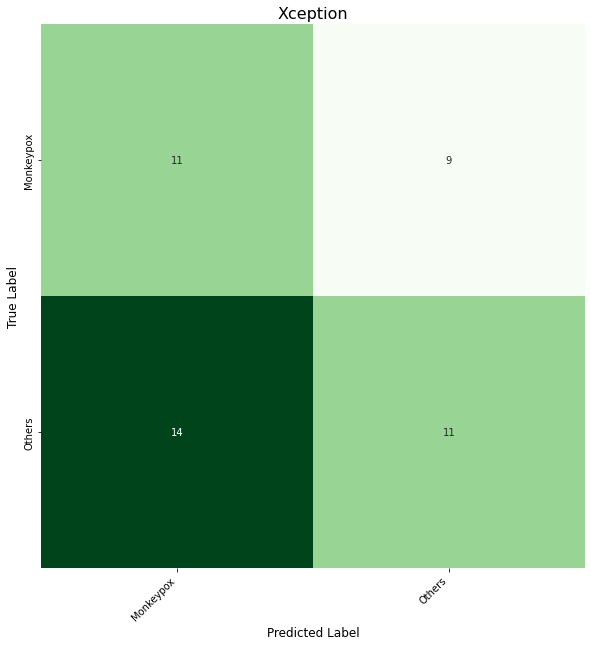

In [19]:
#fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
import seaborn as sns
fig, (ax1) = plt.subplots(1, 1, figsize=(20, 10))
plot_heatmap(true_classes, model_pred_classes, class_names, ax1, title="Xception")    
# plot_heatmap(true_classes, mobilenetv2_pred_classes, class_names, ax2, title="Transfer Learning (mobilenetv2 No Fine-Tuning")    
# plot_heatmap(true_classes, mobilenetv2_pred_classes_ft, class_names, ax3, title="Transfer Learning (mobilenetv2) with Fine-Tuning")    

# fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
# fig.tight_layout()
# fig.subplots_adjust(top=1.25)
# plt.show()

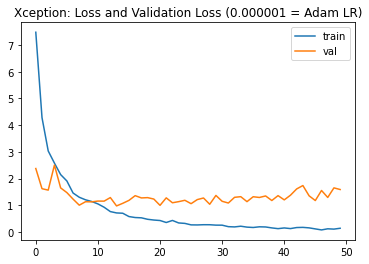

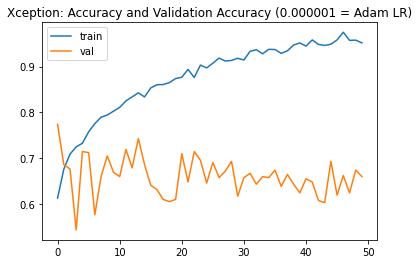

In [20]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Xception: Loss and Validation Loss (0.000001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Xception: Accuracy and Validation Accuracy (0.000001 = Adam LR)')
plt.legend();
plt.show()

In [21]:
true_classes = test_ds.classes

In [22]:
modelspred = model_noFt.predict(test_ds,test_ds.samples//test_ds.batch_size+1)
model_pred_classes = np.argmax(modelspred , axis=1)
print("predicted", model_pred_classes)
print("Actual   ",true_classes)

predicted [1 1 0 0 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1
 0 0 0 1 0 0 1 1]
Actual    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]


In [23]:
ft = 9
# First we'll train the model without Fine-tuning
model_Ft = create_model(input_shape, n_classes, opt, fine_tune=ft)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [24]:
history = model_Ft.fit(train_ds,
                    epochs = 50,
                    #steps_per_epoch = STEP_SIZE_TRAIN,
                    #class_weight = class_weights,
                    validation_data = val_ds,
                    #validation_steps = STEP_SIZE_VALID,
                    #callbacks=[checkpoint, early_stop, PlotLossesKeras()]
                    )

Epoch 1/50
134/134 [==============================] - 14s 86ms/step - loss: 0.6431 - accuracy: 0.6555 - val_loss: 0.6297 - val_accuracy: 0.6048
Epoch 2/50
134/134 [==============================] - 11s 82ms/step - loss: 0.5602 - accuracy: 0.7306 - val_loss: 0.6389 - val_accuracy: 0.6690
Epoch 3/50
134/134 [==============================] - 11s 80ms/step - loss: 0.4804 - accuracy: 0.7932 - val_loss: 0.6744 - val_accuracy: 0.6643
Epoch 4/50
134/134 [==============================] - 11s 80ms/step - loss: 0.3846 - accuracy: 0.8375 - val_loss: 0.6827 - val_accuracy: 0.6167
Epoch 5/50
134/134 [==============================] - 11s 80ms/step - loss: 0.3381 - accuracy: 0.8548 - val_loss: 0.6722 - val_accuracy: 0.6905
Epoch 6/50
134/134 [==============================] - 11s 82ms/step - loss: 0.2739 - accuracy: 0.8889 - val_loss: 0.7952 - val_accuracy: 0.6881
Epoch 7/50
134/134 [==============================] - 11s 80ms/step - loss: 0.2570 - accuracy: 0.8931 - val_loss: 0.7473 - val_accuracy:

In [25]:
model_preds = model_Ft.predict(test_ds,test_ds.samples//test_ds.batch_size+1)
model_pred_classes = np.argmax(model_preds , axis=1)

from sklearn.metrics import accuracy_score
true_classes = test_ds.classes
acc = accuracy_score(true_classes, model_pred_classes)
print("Xception Model Accuracy: {:.2f}%".format(acc * 100))


Xception Model Accuracy: 55.56%


In [26]:
print(confusion_matrix(test_ds.classes, model_pred_classes))
print('Classification Report')
target_names = ['Monkeypox', 'Others']
print(classification_report(test_ds.classes, model_pred_classes, target_names=target_names))

[[10 10]
 [10 15]]
Classification Report
              precision    recall  f1-score   support

   Monkeypox       0.50      0.50      0.50        20
      Others       0.60      0.60      0.60        25

    accuracy                           0.56        45
   macro avg       0.55      0.55      0.55        45
weighted avg       0.56      0.56      0.56        45



(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

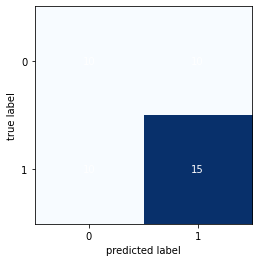

In [27]:
from mlxtend.plotting import plot_confusion_matrix
x = confusion_matrix(test_ds.classes, model_pred_classes)
plot_confusion_matrix(x)

In [28]:
# Get the names of the ten classes
class_names = test_ds.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Greens, #Blues, YlGnBu, YlOrRd
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

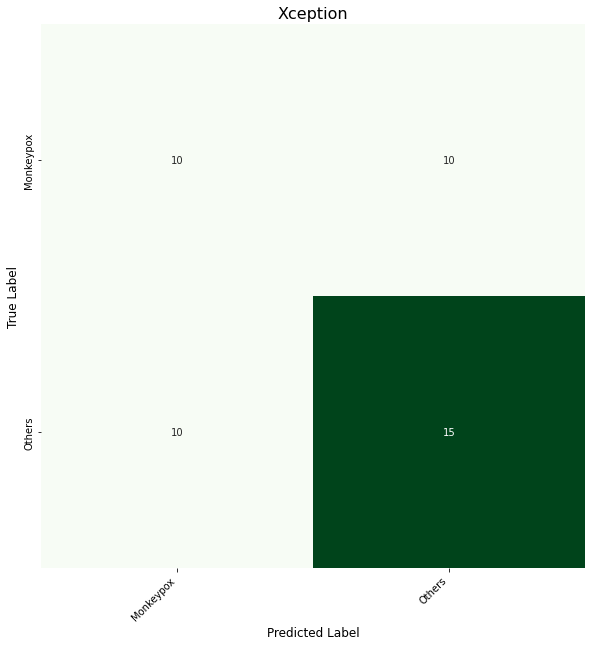

In [29]:
import seaborn as sns
fig, (ax1) = plt.subplots(1, 1, figsize=(20, 10))
plot_heatmap(true_classes, model_pred_classes, class_names, ax1, title="Xception")

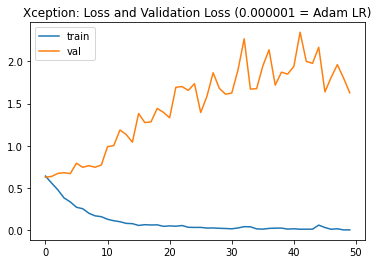

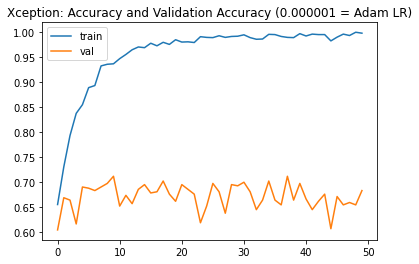

In [30]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Xception: Loss and Validation Loss (0.000001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Xception: Accuracy and Validation Accuracy (0.000001 = Adam LR)')
plt.legend();
plt.show()

In [31]:
true_classes = test_ds.classes
modelspred = model_noFt.predict(test_ds,test_ds.samples//test_ds.batch_size+1)
model_pred_classes = np.argmax(modelspred , axis=1)
print("predicted", model_pred_classes)
print("Actual   ",true_classes)

predicted [1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0
 1 0 0 1 0 1 1 1]
Actual    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
